# Differentiable Atmosphere

This notebook introduces a differentiable atmosphere model useful for propagating satellites in low-Earth orbit with *heyoka.py*.

To do this, we leverage the key observation that the thermosphere as a piecewise exponential behavior with respect to altitude. 

Then, on top of that, the thermosphere is subject to variations at different longitude, latitude, and times, due to seasonal variations, diurnal variations, geomagnetic storms, and more. 

Hence, we write the neutral density profile as a sum of exponentials:

$$
\rho = \sum_i \alpha_i \ \textrm{exp}(-\beta_i (h-\gamma_i))
$$
and we then use a neural network to learn the values of these exponential at different locations, solar conditions and times. In the equation, $h$ is the altitude, and $\alpha_i, \beta_i, \gamma_i$ are the exponential parameters, which will be predicted using a neural network. 

However, to enhance the training, we did not directly learn the coefficients, but we instead first used stochastic gradient descent to find constant coefficients (i.e., $\overline{\alpha}_i, \overline{\beta}_i, \overline{\gamma}_i$) that minimize the loss of the above equation compared to the target density, then we used the feed-forward neural network to only learn a correction to those. In this way, the final coefficients can be expressed as:

$$
\begin{align*}
\alpha_i&=\overline{\alpha}_i+\delta \alpha_i\\
\beta_i&=\overline{\beta}_i+\delta \beta_i\\
\gamma_i&=\overline{\gamma}_i+\delta \gamma_i 
\end{align*}
$$

which means that the neutral density will be written as:


$$
\rho = \sum_i (\overline{\alpha}_i+\delta \alpha_i) \ \textrm{exp}(-\big(\overline{\beta}_i+\delta \beta_i\big) \big(h-(\overline{\gamma}_i+\delta \gamma_i)\big))
$$

Hence, the network will only predict the corrections:
$$
\pmb{x}\rightarrow \mathcal{N}_\theta\rightarrow \delta \alpha_i, \delta \beta_i, \delta \gamma_i 
$$

Here, we refer as $\pmb{x}$ to all the set of input parameters used during network training.

Now, we need to pass the inputs to the neural network. The network has been trained with the following inputs:
* latitude normalized between `[-1,1]`
* sine of longitude 
* cosine of longitude
* sine of seconds in the day, where seconds in the day are first transformed in `[0,2$\pi$]`
* cosine of seconds in the day, where seconds in the day are first transformed in `[0,2$\pi$]`
* F10.7 normalized between `[-1,1]`, using the bounds `[60.,290.]`
* F10.7 81-day average normalized between `[-1,1]`, using the bounds `[60.,190.]`
* Ap index normalized between `[-1,1]`, using the bounds `[0.,140.]`

For training the neural network, we need thermospheric density values that can be used as target. In our case study, we used [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) (a popular empirical density model in the community), however, the same approach can also be extended to other models ([JB-08](https://ccmc.gsfc.nasa.gov/models/JB2008~2008/), [HASDM](https://www.sciencedirect.com/science/article/pii/S0273117705002048), etc.).

The network training was done using [PyTorch](https://pytorch.org/).

In this tutorial, we will instead use an already trained model, whose weights and biases can be found under `data/nrlmsise00_flattened_nw.txt`.
We now load the model flattened weights and biases, and construct the `heyoka.ffnn`

```{note}
for a tutorial on how to load the weights and biases from a torch model to an heyoka.py, check out the tutorial: [Interfacing torch to heyoka.py](<./torch_and_heyoka.ipynb>)
```


In [1]:
#Imports:
import heyoka as hk
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

We now need to instantiate the state variables:

In [2]:
x,y,z,vx,vy,vz=hk.make_vars("x","y","z","vx","vy","vz")

However, the neural network inputs, similar to NRLMSISE-00 and other models, accept the geodetic coordinates as inputs.

Here, we use the method discussed in ["Physical Geodesy" by Heiskanen and Moritz, 1967](https://library.wur.nl/WebQuery/titel/1236290), to transfor the Cartesian coordinates into geodetic ones. 
For the Earth ellipsoid parameters, we use the [WGS-84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS_84) ellipsoid. 

Having said this, this is the method that returns the geodetic coordinates:

In [3]:
#here we use the solution from: "Physical Geodesy" by Heiskanen and Moritz, 1967
def from_position_to_geodetic(x,y,z,a_earth=6378137.0,b_earth=6356752.314245,iters=4):
    long=hk.atan2(y,x)
    p=hk.sqrt(x**2+y**2)
    e=np.sqrt((a_earth**2-b_earth**2)/a_earth**2)
    phi=hk.atan(z/p/(1-e**2))
    #we iterate to improve the solution
    for _ in range(iters):            
        N=a_earth**2/hk.sqrt(a_earth**2*hk.cos(phi)**2+b_earth**2*hk.sin(phi)**2)
        h=p/hk.cos(phi)-N
        phi=hk.atan(z/p/(1-e**2*N/(N+h)))
    return h/1e3,phi,long

In [4]:
altitude,lat,lon=from_position_to_geodetic(x,y,z)

```{note}
In this tutorial, we integrate for about ten hours (i.e., within one day): hence the parameters Ap, F10.7, F10.7 average stay constant, which is why we set them to constant values.
```

In [5]:
lat_n=lat/np.pi*2
sin_lon=hk.sin(lon)
cos_lon=hk.cos(lon)
date0=datetime.datetime(2009, 1, 2, 15, 0)
offset=date0.second+date0.minute*60.+date0.hour*3600.
sec_in_day_n=(hk.time+offset)/86400.*2*np.pi
cos_sec_in_day=hk.cos(sec_in_day_n)
sin_sec_in_day=hk.sin(sec_in_day_n)
f107_n, f107A_n, ap_n=(0.17409463226795197, -0.5575244426727295, 0.1701483279466629)

We load the pre-trained weights and biases for the `ffnn`:

In [6]:
flattened_nw=np.loadtxt('data/nrlmsise00_flattened_nw.txt')

We are now ready to instantiate the `heyoka.ffnn`:

In [7]:
model_heyoka=hk.model.ffnn(inputs=[lat_n,sin_lon,cos_lon,sin_sec_in_day, cos_sec_in_day, hk.expression(f107_n), hk.expression(f107A_n), hk.expression(ap_n)],
                           nn_hidden=[32,32], 
                           n_out=12, 
                           activations=[hk.tanh,hk.tanh,hk.tanh], 
                           nn_wb=flattened_nw)


The above network predicts the correction to the parameters of the exponentials (i.e., $\delta \alpha_i$, $\delta \beta_i$, $\delta \gamma_i$, to use the terminology above).

Thus, to reconstruct the density, we shall first define a function that composes the sum of exponentials:

In [8]:
#this are the constant
fit_params_all=np.zeros((1,12))
fit_params_all[0,0]=1.1961831205553608e-06
fit_params_all[0,3]=0.7521974444389343
fit_params_all[0,6]=3.916130530967621e-09
fit_params_all[0,9]=1.4778674432228828e-13
fit_params_all[0,1]=0.04639218747615814
fit_params_all[0,4]=0.18178749084472656
fit_params_all[0,7]=0.019965510815382004
fit_params_all[0,10]=0.004425965249538422
fit_params_all[0,2]=5.996347427368164
fit_params_all[0,5]=21.895925521850586
fit_params_all[0,8]=2.3234505653381348
fit_params_all[0,11]=0.26730024814605713
def neutral_density(altitude, 
                    model_heyoka,
                    factor=0.9):
    density=0.
    for i in range(0,fit_params_all.shape[1]-1,3):
        density += (fit_params_all[0,i].item()*(1+factor*model_heyoka[i])*hk.exp(-fit_params_all[0,i+1].item()*(1.+factor*model_heyoka[i+1])*(altitude-(fit_params_all[0,i+2].item()*(1.+factor*model_heyoka[i+2])))))
    return density

Let's now use the function to instantiate the neutral density model with feed-forward neural network correction:

In [9]:
density_nn = neutral_density(altitude=altitude, 
                            model_heyoka=model_heyoka)

All right, but the above model uses constant values for the weights & biases: what if I want to symbolically write the neural network output using the weights and biases as symbols? 

*heyoka.py* lets you do this:

In [10]:
##### Parametric NN #####
model_heyoka_par=hk.model.ffnn(inputs=[lat_n,sin_lon,cos_lon,sin_sec_in_day, cos_sec_in_day, hk.expression(f107_n), hk.expression(f107A_n), hk.expression(ap_n)],
                           nn_hidden=[32,32], 
                           n_out=int(3*4), 
                           activations=[hk.tanh,hk.tanh,hk.tanh])
density_par = neutral_density(altitude=altitude, 
                              model_heyoka=model_heyoka_par)

Let's now do the same, but zeroing out the correction terms: this corresponds to the neutral density model optimized to represent the target density, but with constant coefficients

In [11]:
density_fit_global = neutral_density(altitude=altitude,
                                    model_heyoka=model_heyoka, 
                                    factor=0.)

## Numerical Integration with Differentiable Atmosphere

All right... we have constructed the neutral density model using a NN, and using a global fit. How can these be used for predicting the orbit of a satellite in low-Earth orbit? And how do they compare to `scipy` integration using the `NRLMSISE-00` model itself?

Let's investigate this..

First some useful constants:

In [12]:
#First we need to set some variables useful for integration:
mu = 3.986004407799724e14   #Earth gravitational parameter SI
r_earth = 6378.1363*1e3     #Earth radius SI
initial_h=350.*1e3          #Satellite's initial altitude SI
mass=200                    #mass of the satellite SI
area=2#                     drag cross-sectional area of the satellite in SI
cd=2.2#                     drag coefficient [-]
bc = mass/(cd*area)         #ballistic coefficient in SI
#we assume a circular orbit at first
initial_state=[r_earth+initial_h,0.,0., 0., np.sqrt(mu/(r_earth+initial_h)),0.]
#finally, we need to de-normalize the solar indices of the day of the integration:
f107=(1+f107_n)/2*(290.-60.)+60.
f107A=(1+f107A_n)/2*(190.-60.)+60.
ap=(1+ap_n)/2*(140.-0.)+0.


### Scipy + NRLMSISE-00

This is the standard scipy integration, using NRLMSISE-00 as neutral density model

```{warning}
to run this, the [nrlmsise00](https://pypi.org/project/nrlmsise00/) pypi package shall be first installed
```

First, we define the dynamics:

In [13]:
from scipy.integrate import solve_ivp
from nrlmsise00 import msise_flat
def from_position_to_geodetic_(x,y,z,a_earth=6378137.0,b_earth=6356752.314245,iters=4):
    long=np.arctan2(y,x)
    p=np.sqrt(x**2+y**2)
    e=np.sqrt((a_earth**2-b_earth**2)/a_earth**2)
    phi=np.arctan(z/p/(1-e**2))
    #we iterate to improve the solution
    for _ in range(iters):            
        N=a_earth**2/np.sqrt(a_earth**2*np.cos(phi)**2+b_earth**2*np.sin(phi)**2)
        h=p/np.cos(phi)-N
        phi=np.arctan(z/p/(1-e**2*N/(N+h)))
    return h/1e3,phi,long

def dxdt(t, state, mu, f107A, f107, ap, bc, date0):
    x,y,z,vx,vy,vz=state
    r=np.sqrt(x**2+y**2+z**2)
    h,lat,long=from_position_to_geodetic_(x,y,z)
    #nrlmsise-00 density (takes: datetime, altitude [km], latitude [deg], longitude [deg], f107, f107A, ap)
    rho=msise_flat(time=date0+datetime.timedelta(seconds=t), alt=h, lat=np.rad2deg(lat), lon=np.rad2deg(long), f107a=f107A, f107=f107, ap=ap)[5]*1e3
    adrag_x=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vx/bc
    adrag_y=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vy/bc
    adrag_z=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vz/bc
    ax=-mu*x/r**3+adrag_x
    ay=-mu*y/r**3+adrag_y
    az=-mu*z/r**3+adrag_z
    return np.array([vx,vy,vz,ax,ay,az])
    

Then, we set up the integration:
    
```{note}
To have a fair comparison, as integrator, we use `DOP853` with absolute and relative tolerances of $10^{-14}$, and we then select the same tolerances for the Taylor integrator)
```

In [14]:
t_span=(0.,60.*60*10.) #10 hours propagation

start_time = time.time()
sol = solve_ivp(dxdt, 
                t_span, 
                initial_state, 
                args=(mu, f107A, f107, ap, bc, date0), 
                method='DOP853',
                rtol=1e-14,
                atol=1e-14)
print("--- %s seconds --- to propagate" % (time.time() - start_time))

res_x_scipy_nrlmsise00=sol.y[0,:]
res_y_scipy_nrlmsise00=sol.y[1,:]
res_z_scipy_nrlmsise00=sol.y[2,:]
res_vx_scipy_nrlmsise00=sol.y[3,:]
res_vy_scipy_nrlmsise00=sol.y[4,:]
res_vz_scipy_nrlmsise00=sol.y[5,:]


/Users/ga00693/miniconda3/envs/diff_drag_py38/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


--- 0.6513950824737549 seconds --- to propagate


### Heyoka + Neutral Density NN surrogate

Here we do the same as above, but using `heyoka`'s Taylor method, and the differentiable atmosphere model.

First, we define the dynamics:

In [15]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

adragx=-1/2*density_nn*vx*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragy=-1/2*density_nn*vy*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragz=-1/2*density_nn*vz*hk.sqrt(vx**2+vy**2+vz**2)/bc

dyn_drag=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]

rhs_w_drag = hk.make_cfunc(fn = [it[1] for it in dyn_drag], 
                    compact_mode=True, 
                    vars = [x,y,z,vx,vy,vz])


We first compile the integrator:

In [16]:
start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')

0.4697380065917969 to build the integrator


And then, we can finally perform the integration:

In [17]:
ta.state[:] = initial_state
ta.time=0.
# For profiling
start_time = time.time()
#ta.propagate_until(60.*60*10.)
sol_heyoka_nn=ta.propagate_grid(sol.t)
print("--- %s seconds --- to propagate using the Taylor scheme" % (time.time() - start_time))
res_x_heyoka_nn=sol_heyoka_nn[-1][:,0]
res_y_heyoka_nn=sol_heyoka_nn[-1][:,1]
res_z_heyoka_nn=sol_heyoka_nn[-1][:,2]
res_vx_heyoka_nn=sol_heyoka_nn[-1][:,3]
res_vy_heyoka_nn=sol_heyoka_nn[-1][:,4]
res_vz_heyoka_nn=sol_heyoka_nn[-1][:,5]

--- 0.0031218528747558594 seconds --- to propagate using the Taylor scheme


*heyoka.py* integration with a differentiable atmosphere is more than 100x times faster than `scipy` with `NRLMSISE-00` !

Well, does this number increase if we use a parametric neural network? Let's check:

### Heyoka + Parametric Neutral Density NN Surrogate

Same as above, but now instead of using constant values for weights and biases, we build a symbolic representation of the neural network and we treat them as heyoka parameters.

First the dynamics:

In [18]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

adragx=-1/2*density_par*vx*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragy=-1/2*density_par*vy*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragz=-1/2*density_par*vz*hk.sqrt(vx**2+vy**2+vz**2)/bc

dyn_drag_par=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]


We compile the integrator:

In [19]:
start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag_par,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')

0.5227298736572266 to build the integrator


Slightly longer compilation time. What about integration of the equations of motion?

In [20]:
ta.state[:] = initial_state
ta.time=0.
ta.pars[:]=flattened_nw
# For profiling
start_time = time.time()
sol_heyoka_nn_par=ta.propagate_grid(sol.t)
print("--- %s seconds --- to propagate using the Taylor scheme" % (time.time() - start_time))

res_x_heyoka_nn_par=sol_heyoka_nn_par[-1][:,0]
res_y_heyoka_nn_par=sol_heyoka_nn_par[-1][:,1]
res_z_heyoka_nn_par=sol_heyoka_nn_par[-1][:,2]
res_vx_heyoka_nn_par=sol_heyoka_nn_par[-1][:,3]
res_vy_heyoka_nn_par=sol_heyoka_nn_par[-1][:,4]
res_vz_heyoka_nn_par=sol_heyoka_nn_par[-1][:,5]

--- 0.004960060119628906 seconds --- to propagate using the Taylor scheme


Slightly faster than before!

*heyoka.py* has maintained its more than 100x factor speedup compared to `scipy` and `NRLMSISE-00`

All right! But what about the accuracy? Does the trained neural network manage to accurately represent `NRLMSISE-00`, without accumulating too much error during integration?

For this, we setup a test where we compare: 
* scipy with `NRLMSISE-00`
* heyoka with NN
* heyoka with global fit

But first, let's integrate the equations of motion using the global fit:


In [21]:

akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

adragx=-1/2*density_fit_global*vx*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragy=-1/2*density_fit_global*vy*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragz=-1/2*density_fit_global*vz*hk.sqrt(vx**2+vy**2+vz**2)/bc

dyn_drag_fit_global=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]

start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag_fit_global,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')

ta.state[:] = initial_state
ta.time=0.
# For profiling
start_time = time.time()
#ta.propagate_until(60.*60*10.)
sol_heyoka_fit_global=ta.propagate_grid(sol.t)
print("--- %s seconds --- to propagate using the Taylor scheme" % (time.time() - start_time))

res_x_heyoka_fit_global=sol_heyoka_fit_global[-1][:,0]
res_y_heyoka_fit_global=sol_heyoka_fit_global[-1][:,1]
res_z_heyoka_fit_global=sol_heyoka_fit_global[-1][:,2]
res_vx_heyoka_fit_global=sol_heyoka_fit_global[-1][:,3]
res_vy_heyoka_fit_global=sol_heyoka_fit_global[-1][:,4]
res_vz_heyoka_fit_global=sol_heyoka_fit_global[-1][:,5]

0.24403095245361328 to build the integrator
--- 0.0003769397735595703 seconds --- to propagate using the Taylor scheme


Wow! This is even more than 1000x faster than `scipy` with `NRLMSISE-00`. But does it maintain an acceptable accuracy? Let's see:

Text(0.5, 0, 'time [s]')

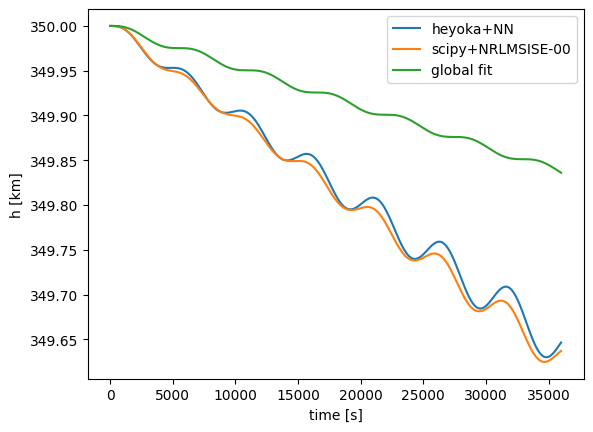

In [22]:
plt.plot(sol.t,(np.sqrt(res_x_heyoka_nn**2+res_y_heyoka_nn**2+res_z_heyoka_nn**2)-r_earth)*1e-3,label='heyoka+NN')
plt.plot(sol.t,(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3,label='scipy+NRLMSISE-00')
plt.plot(sol.t,(np.sqrt(res_x_heyoka_fit_global**2+res_y_heyoka_fit_global**2+res_z_heyoka_fit_global**2)-r_earth)*1e-3,label='global fit')
plt.legend()
plt.ylabel('h [km]')
plt.xlabel('time [s]')

In [23]:
print("######### global fit vs NRLMSISE-00 #########")
print("Maximum error across the integration period:",1e3*max(abs((np.sqrt(res_x_heyoka_fit_global**2+res_y_heyoka_fit_global**2+res_z_heyoka_fit_global**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3)))
print("Final error:",1e3*(abs((np.sqrt(res_x_heyoka_fit_global[-1]**2+res_y_heyoka_fit_global[-1]**2+res_z_heyoka_fit_global[-1]**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00[-1]**2+res_y_scipy_nrlmsise00[-1]**2+res_z_scipy_nrlmsise00[-1]**2)-r_earth)*1e-3)))

print("\n\n######### NN vs NRLMSISE-00 #########")
print("Maximum error across the integration period:",1e3*max(abs((np.sqrt(res_x_heyoka_nn**2+res_y_heyoka_nn**2+res_z_heyoka_nn**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3)))
print("Final error:",1e3*(abs((np.sqrt(res_x_heyoka_nn[-1]**2+res_y_heyoka_nn[-1]**2+res_z_heyoka_nn[-1]**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00[-1]**2+res_y_scipy_nrlmsise00[-1]**2+res_z_scipy_nrlmsise00[-1]**2)-r_earth)*1e-3)))



######### global fit vs NRLMSISE-00 #########
Maximum error across the integration period: 222.9247824801064
Final error: 199.04158257600102


######### NN vs NRLMSISE-00 #########
Maximum error across the integration period: 22.077906946663006
Final error: 9.452653449045556


As we notice, the differentiable atmosphere manages to capture very well the underlying behavior of NRLMSISE-00, maintaining (for 10 hours integrations) errors always below 23 meters, with a final error of 9.45 meters, in the altitude of the satellite at an initial altitude of 350km (where drag is one of the main perturbations).

Conversely, a global fit does not manage to maintain the same accuracy, reaching errors as high as 223 meters, and a final error of 200 meters.